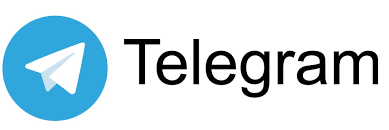

---

# **Projeto** | Pipeline de Dados para Análise de Mensagens do Telegram



---

# **Sumário**

<ol type="1">
  <li>Projeto</li>
  <li>Telegram</li>
  <li>Dados</li>
  <li>Ingestão</li>
  <li>ETL</li>
  <li>Apresentação</li>
  <li>Análises</li>
  <li>Conclusões</li>

</ol>

---

## 1\. Projeto

## 1.1. Contexto
A análise de dados de chatbots transcende a operacionalização, visando a extração de valor estratégico através da conversão de dados transacionais em insights analíticos.  Cada interação,  registrada com atributos como data, hora, assunto e fluxo da conversa, constitui uma transação.  Embora essenciais, esses dados isoladamente oferecem uma visão limitada.

Este projeto utiliza um pipeline ETL para transformar dados brutos em informações acionáveis. Técnicas de data wrangling garantem a qualidade dos dados,  resultando em um conjunto de dados enriquecido para análise. A arquitetura, baseada em AWS Lambda, S3 e EventBridge, garante escalabilidade e eficiência, enquanto o formato de dados orientado a colunas e comprimido (e.g., Apache Parquet) maximiza a performance analítica.

A análise resultante permite:

* Identificar padrões de uso e tendências.
* Avaliar a efetividade do chatbot.
* Otimizar o design e a funcionalidade.
* Personalizar a interação com o usuário.

## 1.2 Arquitetura
<p>Em vista disso, a arquitetura desse projeto se divide em duas partes (vide Fluxograma):</p>

<h2>Fluxograma:</h2>

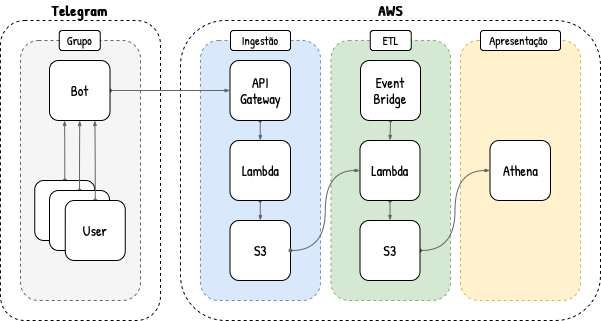



<h3>1.2.1. Transacional (Telegram)</h3>

<ul>
<li><b>Fonte de dados:</b> Mensagens enviadas pelos usuários em um grupo do Telegram.</li>
<li><b>Captura:</b> Um bot captura as mensagens e as redireciona via webhook para um endpoint na AWS.</li>
</ul>

<h3>1.2.2. Analítica (AWS)</h3>

<ul>
<li><b>Ingestão:</b>
<ul>
<li>O AWS API Gateway recebe as requisições HTTP com as mensagens e as redireciona para o AWS Lambda.</li>
<li>O AWS Lambda salva as mensagens em arquivos JSON no AWS S3, particionados por dia.</li>
</ul>
</li>
<li><b>ETL (Extract, Transform, Load):</b>
<ul>
<li>Diariamente, o AWS Event Bridge aciona o AWS Lambda para processar as mensagens do dia anterior.</li>
<li>O AWS Lambda denormaliza os dados e os salva em arquivos Parquet no AWS S3, particionados por dia.</li>
</ul>
</li>
<li><b>Apresentação:</b>
<ul>
<li>Uma tabela do AWS Athena é criada, apontando para o bucket do S3 com os dados processados.</li>
<li> Usa-se o SQL para consultar a tabela e extrair insights.</li>
</ul>
</li>
</ul>






## 2\. Telegram

Para começar a acessar os dados do Telegram necessita-se realizar ao menos 3 passos, quais sejam:

<h3>Passo 1: Criação do Bot</h3>

<p>Usa-se o <a href="https://telegram.me/BotFather" target="_blank">BotFather</a> no Telegram para criar um bot, seguindo as instruções do BotFather para:</p>

<ol>
  <li>Criar um novo bot com o comando <code>/newbot</code>.</li>
  <li>Escolher um nome para o bot.</li>
  <li>Definir um nome de usuário único para o bot (terminando com "bot").</li>
  <li>Obter o token de acesso do bot.
</ol>

<h3>Passo 2: Configuração do Grupo</h3>

<ol>
  <li>Adiciona-se o bot ao grupo desejado.</li>
  <li>Nas configurações do grupo, torna-se o bot um administrador. Certificando que ele tenha permissão para ler mensagens e enviar mensagens.</li>
</ol>

<h3>Passo 3: Implementação do Código (Python)</h3>

<p>Para garantir a segurança, a biblioteca getpass é utilizada para capturar o token do bot sem revelar a senha. A biblioteca requests entra em ação para enviar requisições HTTP à API, estabelecendo a comunicação entre o código e o servidor do Telegram. E para interpretar as respostas da API, que vêm no formato JSON, a biblioteca json é a ferramenta ideal.</p>


2.2. Criação do *bot* com auxilío do BotFather presente no próprio Telegram

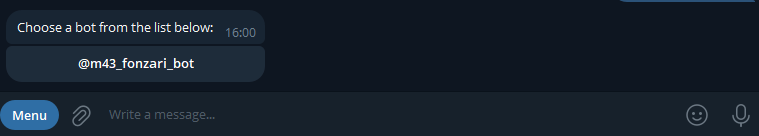

2.2. Criação do grupo e adição do *bot*.

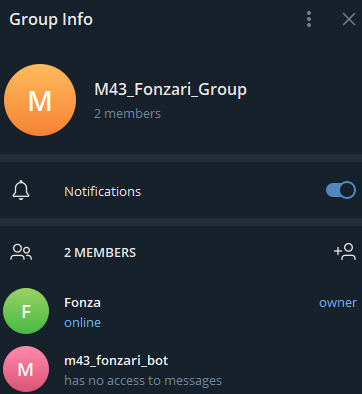

2.3. *bot* administrador do grupo.

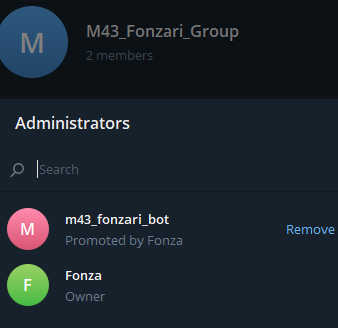

2.4. Armazenamento de Token

In [ ]:
from getpass import getpass

token = getpass()

··········


2.5. Definição da URL base para as requisições à API do Telegram

In [ ]:
import json
import requests

base_url = f'https://api.telegram.org/bot{token}'

2.6. Uso do getMe da API do Telegram para obter informações sobre o bot e formatação da resposta JSON para facilitar a leitura.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')
print(f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

2.7. Busca de atualizações do Telegram para o bot e impressão dessas atualizações formatadas

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

## 3\. Dados

<p> Conforme supracitado, o projeto tem como objetivo analisar dados provenientes de mensagens de texto do Telegram. A extração desses dados se dará através da API do Telegram, que os disponibiliza no formato JSON (JavaScript Object Notation).</p>

  <p>É importante salientar que a estrutura JSON das mensagens varia conforme o tipo de conteúdo (texto, áudio, imagem, etc.). Cada mensagem é representada por um objeto JSON que contém um conjunto de pares chave-valor. Vide saída abaixo: </p>



In [ ]:
%%writefile telegram.json


    {
      "update_id": 38888292,
      "message": {
        "message_id": 45,
        "from": {
          "id": 1523949157,
          "is_bot": false,
          "first_name": "Fonza",
          "username": "Fonzari",
          "language_code": "pt-br"
        },
        "chat": {
          "id": XXXXXXXXXX,
          "title": "M43_Fonzari_Group",
          "type": "supergroup"
        },
        "date": 1731787579,
        "text": "Ola, mundo!"
      }
    }




### 3.1. Descrição de Chaves JSON


  <ul>
    <li><b>Obrigatórias:</b> Presentes em todos os tipos de mensagens, como <code>chat_id</code>, <code>message_id</code> e <code>date</code>.</li>
    <li><b>Opcionais:</b> Dependem do tipo de mensagem. Por exemplo, a chave <code>text</code> está presente apenas em mensagens de texto.</li>
  </ul>

  <p>A análise de dados deste projeto se concentrará especificamente nas mensagens de texto e nas informações contidas em suas respectivas chaves, ignorando outros tipos de mensagens e suas particularidades. A partir da extração e análise do conteúdo textual, pretende-se obter insights relevantes sobre a comunicação no Telegram.</p>


| chave | tipo valor | opcional | descrição |
| -- | -- | -- | -- |
| updated_id | int | não | id da mensagem enviada ao **bot** |
| message_id | int | não | id da mensagem enviada ao grupo |
| from_id | int | sim | id do usuário que enviou a mensagem |
| from_is_bot | bool | sim | se o usuário que enviou a mensagem é um **bot** |
| from_first_name | str | sim | primeiro nome do usário que enviou a mensagem |
| chat_id | int | não | id do *chat* em que a mensagem foi enviada |
| chat_type | str | não | tipo do *chat*: private, group, supergroup ou channel |
| date | int | não | data de envio da mensagem no formato unix |
| text | str | sim | texto da mensagem |

A tabela descreve as chaves JSON presentes em mensagens recebidas por bots do Telegram. Essas chaves, com seus tipos (int, str, bool) e opcionalidade, permitem a extração de dados da mensagem, como tipo de conteúdo, informações do remetente e detalhes do chat. A análise dessas informações é crucial para o desenvolvimento de bots que respondam adequadamente às interações dos usuários.










 ### 3.2. Wrangling


A etapa de *Wrangling* visa transformar os dados semi-estruturados em JSON das mensagens do Telegram.  Para isso, o projeto utilizará Python nativo (sem pacotes como Pandas) para denormalizar o conteúdo do arquivo telegram.json,  começando com a leitura do arquivo através do pacote json.









3.2.1. Leitura do arquivo JSON "telegram.json" e extrai os dados associados à chave "message"

In [ ]:
import json

with open('telegram.json', mode='r', encoding='utf8') as fp:
  data = json.load(fp)
  data = data["message"]


3.2.2. Uso de um laço para percorrer as chaves do arquivo, filtrando apenas as relevantes. Se text não existir, será definida como None. Adicionaremos context_date e context_timestamp para marcar o momento do processamento.

In [ ]:
from datetime import datetime

date = datetime.now().strftime('%Y-%m-%d')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

parsed_data = dict()

for key, value in data.items():

    if key == 'from':
        for k, v in data[key].items():
            if k in ['id', 'is_bot', 'first_name']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
        for k, v in data[key].items():
            if k in ['id', 'type']:
              parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
        parsed_data[key] = [value]

if not 'text' in parsed_data.keys():
  parsed_data['text'] = [None]

parsed_data['context_date'] = [date]
parsed_data['context_timestamp'] = [timestamp]

In [ ]:
for k, v in parsed_data.items():
  print(f"{k}: {v}")

3.2.3. Uso do pacote Python PyArrow para criar uma tabela com os dados processados

In [ ]:
import pyarrow as pa

table = pa.Table.from_pydict(mapping=parsed_data)

## 4\. Ingestão

<p> A ingestão visa apturar dados transacionais e armazená-los em formato bruto (sem transformações) para análise posterior.</p>

  <h3>Formato de Dados</h3>
  <p>JSON (no caso do projeto com a API do Telegram).</p>

  <h3>Métodos de Ingestão</h3>
  <ul>
    <li><b>Batch:</b> Ingestão de blocos de dados em intervalos regulares (horas/dias).</li>
    <li><b>Streaming:</b> Ingestão contínua de dados em tempo real.</li>
  </ul>

  <h3>Estratégia para o Projeto</h3>
  <ul>
    <li><b>Streaming:</b> Ideal para capturar mensagens do Telegram antes que expirem (24h).</li>
    <li><b>Webhook:</b> Redirecionamento automático das mensagens para a API de análise.</li>
  </ul>

  <h3>Vantagens</h3>
  <ul>
    <li>Preservação dos dados originais.</li>
    <li>Possibilidade de reprocessamento.</li>
  </ul>


A ingestão de dados transacionai nesse projeto ocorre em duas etapas:

<h3>1. Captura dos dados:</h3>



*  Os dados são capturados em seu formato original (JSON, no caso do Telegram) via streaming, utilizando um webhook para redirecionamento automático.
* O AWS API Gateway recebe os dados redirecionados.

<h3>2. Armazenamento dos dados:</h3>




*   O AWS API Gateway redireciona os dados para o AWS Lambda.

*   O AWS Lambda armazena os dados em formato JSON em um bucket do AWS S3.




### 4.1 Código da função Lambda





In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

### 4.2. Configuração do API Gateway

<h3>A integração exige:</h3>

<ol>
  <li><b>Criação de uma API REST no API Gateway:</b> Acessa-se o serviço API Gateway no console da AWS e cria-se uma nova API do tipo REST. </li>
  <li><b>Criação de método POST:</b> Para receber as mensagens do Telegram, cria-se um método POST na API. Esse método é responsável por receber as informações enviadas pelo Telegram.</li>
  <li><b>Configuração de integração com a função Lambda:</b>
    <ul>
      <li>Em "Integration type", escolhe-se "Lambda Function".</li>
      <li>Habilita-se a opção "Use Lambda Proxy integration".</li>
      <li>Seleciona-se a função Lambda que irá processar as mensagens.</li>
    </ul>
  </li>
  <li><b>Teste de integração:</b> Utiliza-se a ferramenta de testes do API Gateway para verificar se a API está se comunicando corretamente com a função Lambda.</li>
  <li><b>Implantação da API:</b> Cria-se um novo estágio de implantação (ex: "dev", "test", "prod") para que a API possa ser acessada.</li>
</ol>

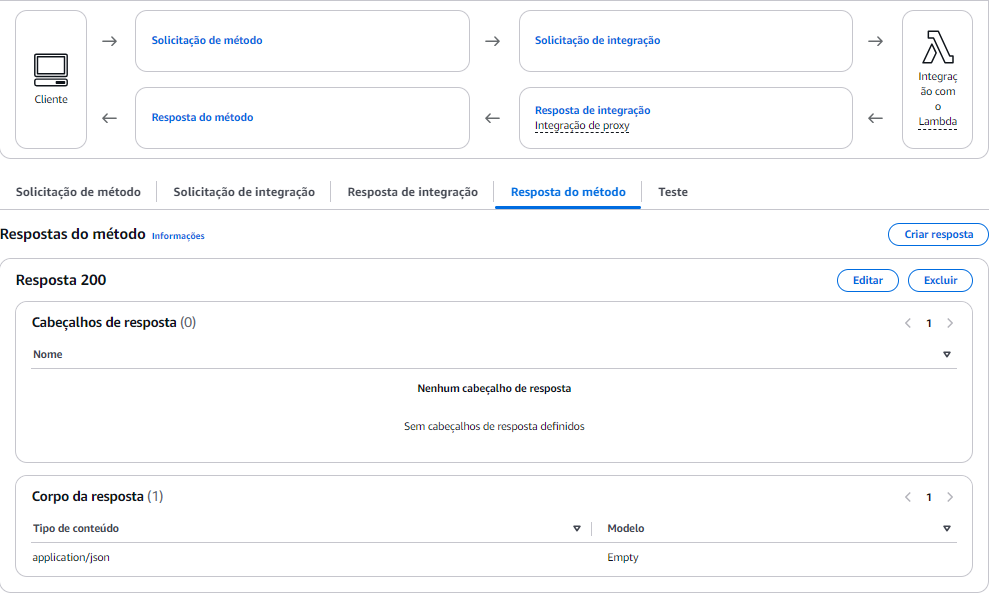

Após a criação da API no AWS API Gateway, é necessário configurar o webhook do bot para receber as atualizações do Telegram (Webhooks são como "avisos automáticos" que um aplicativo envia para outro quando algo acontece). Isso é feito através do método setWebhook da API de bots do Telegram, utilizando o endereço da API criada no API Gateway como parâmetro.

In [ ]:
import requests

response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

Para verificar se a integração foi bem-sucedida, pode-se usar o método getWebhookInfo, que retorna informações sobre a configuração atual do webhook.

In [ ]:
import requests
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

## 5\. ETL

<h3> Processo de ETL (Extração, Transformação e Carga):</h3>

<p>O processo de ETL neste projeto visa otimizar dados de mensagens diárias para análise.</p>

<p>Os dados brutos (raw), inicialmente armazenados em um bucket S3, são submetidos a um processo de data wrangling, incluindo limpeza e deduplicação. Em seguida, são compactados em um único arquivo orientado a colunas e comprimido, otimizado para análise.</p>

<p>A orquestração do processo é realizada por uma função AWS Lambda, disparada diariamente por uma regra do AWS EventBridge. Essa função realiza as etapas de ETL e armazena o arquivo processado em um bucket S3 designado como camada enriquecida.</p>

<h3>Tecnologias empregadas:</h3>

<ul>
  <li><b>AWS Lambda:</b> Motor de processamento para execução do ETL.</li>
  <li><b>AWS S3:</b> Armazenamento dos dados brutos (raw) e processados (camada enriquecida).</li>
  <li><b>AWS EventBridge:</b> Orquestração e agendamento da função Lambda.</li>
</ul>

<h3>Formato de dados:</h3>

<ul>
  <li><b>Orientado a colunas e comprimido.</b></ul>

<h3>Técnicas:</h3>

<ul>
  <li><b>Data Wrangling.</b></ul>

<p>Essa abordagem garante a automatização do processo de ETL, otimizando o armazenamento e a performance para análises subsequentes.</p>

###5.1. Criação do Bucket

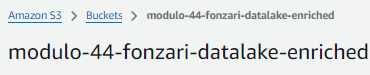

##5.2. Função Lambda

Criação de uma função no AWS Lambda para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no bucket de dados crus. O resultado é salvo em um único arquivo PARQUET, também particionado por dia.

Adicionalmente, aplica-se um padrão de schema para o PARQUET para evitar erros de schema.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq

def lambda_handler(event: dict, context: dict) -> bool:

    '''
    Diariamente é executado para compactar as diversas mensagens, no formato
    JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
    arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
    '''

    # vars de ambiente
    RAW_BUCKET = os.environ['AWS_S3_BUCKET']
    ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

    # vars lógicas
    tzinfo = timezone(offset=timedelta(hours=-3))
    date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
    # date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')

    timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

    # Define o esquema explicitamente
    schema = pa.schema([
        ('message_id', pa.int64()),
        ('user_id', pa.int64()),
        ('user_is_bot', pa.bool_()),
        ('user_first_name', pa.string()),
        ('chat_id', pa.int64()),
        ('chat_type', pa.string()),
        ('date', pa.int64()),
        ('text', pa.string())  # Define o tipo como string, permitindo nulos
    ])

    # código principal
    table = None
    client = boto3.client('s3')

    try:
        response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

        for content in response['Contents']:
            key = content['Key']
            client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

            with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:
                data = json.load(fp)
                data = data["message"]

            parsed_data = parse_data(data=data)

            # Usa o esquema definido ao criar a tabela
            iter_table = pa.Table.from_pydict(mapping=parsed_data, schema=schema)

            if table:
                table = pa.concat_tables([table, iter_table])
            else:
                table = iter_table
                iter_table = None

        pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
        client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

        return True

    except Exception as exc:
        logging.error(msg=exc)
        return False


def parse_data(data: dict) -> dict:
    date = datetime.now().strftime('%Y-%m-%d')
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    parsed_data = dict()

    for key, value in data.items():
        if key == 'from':
            for k, v in data[key].items():
                if k in ['id', 'is_bot', 'first_name']:
                    parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]
        elif key == 'chat':
            for k, v in data[key].items():
                if k in ['id', 'type']:
                    parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]
        elif key in ['message_id', 'date', 'text']:
            parsed_data[key] = [value]

    if not 'text' in parsed_data.keys():
        parsed_data['text'] = [None]

    return parsed_data

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

### 5.3. Regra no AWS Event Bridge

Para executar uma função Lambda todo dia à meia-noite (horário de Brasília), faz-se uma configuração de uma regra no EventBridge. Serviço que torna possível  definir um agendamento com uma expressão cron que represente esse horário, considerando o fuso horário GMT-3. A regra acionará a função no horário especificado.



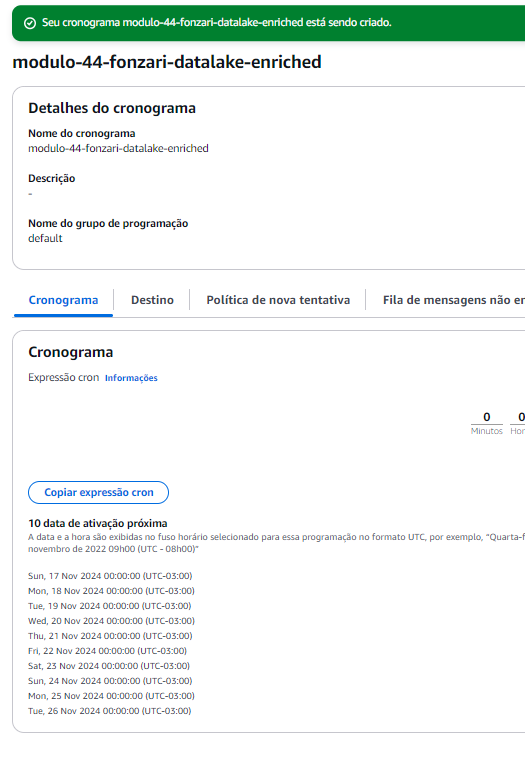

#6. Apresentação

A análise dos dados enriquecidos é realizada através do AWS Athena. Uma tabela é configurada para acessar diretamente o bucket S3 onde os dados estão armazenados








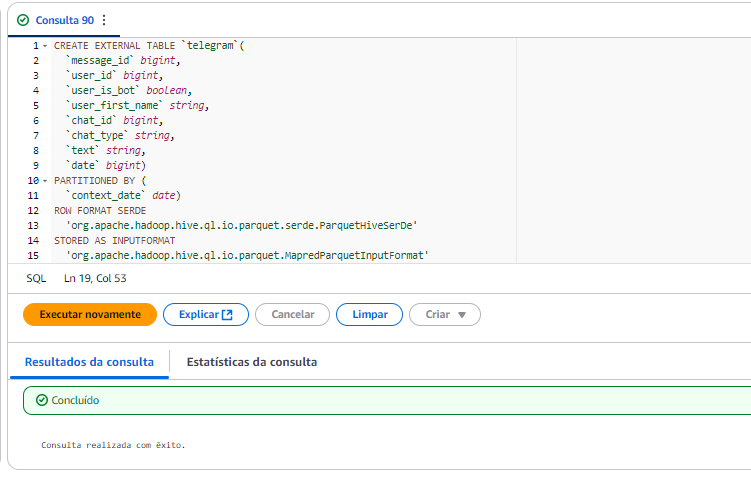

Após particionar os dados para otimizar o tempo de consulta, o comando MSCK REPAIR TABLE foi executado no Athena. Isso garante que a tabela reconheça as novas partições e permita consultas eficientes

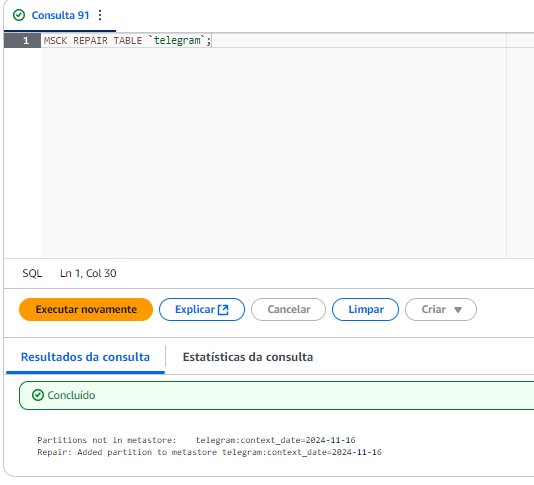

### 6.1. Quantidade de mensagens por dia.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

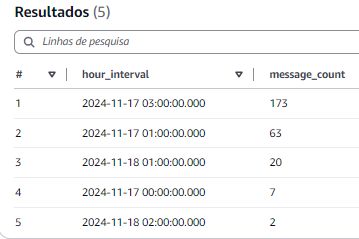!

### 6.2. Média do tamanho das mensagens por usuário por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

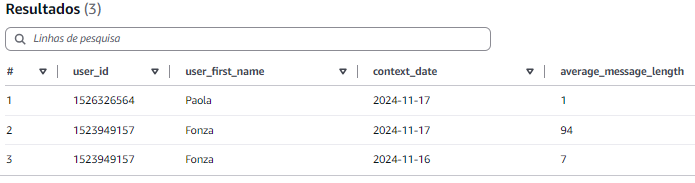

### 6.3. Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

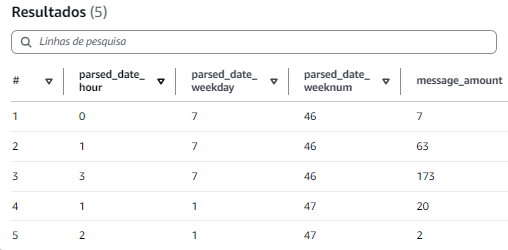

### 6.4 Quantidade de mensagens repetidas

```sql
WITH parsed_date_cte AS (
    SELECT
        CAST(from_unixtime("date") AS timestamp) AS parsed_date,
        text
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
),
repeated_messages_cte AS (
    SELECT
        parsed_date_hour,
        parsed_date_weekday,
        parsed_date_weeknum,
        text,
        COUNT(*) AS message_count
    FROM hour_week_cte
    GROUP BY
        parsed_date_hour,
        parsed_date_weekday,
        parsed_date_weeknum,
        text
    HAVING
        COUNT(*) > 1
)
SELECT
    rm.parsed_date_hour,
    rm.parsed_date_weekday,
    rm.parsed_date_weeknum,
    rm.text,
    rm.message_count
FROM repeated_messages_cte rm
ORDER BY
    rm.parsed_date_weeknum,
    rm.parsed_date_weekday,
    rm.parsed_date_hour,
    rm.message_count DESC;
```

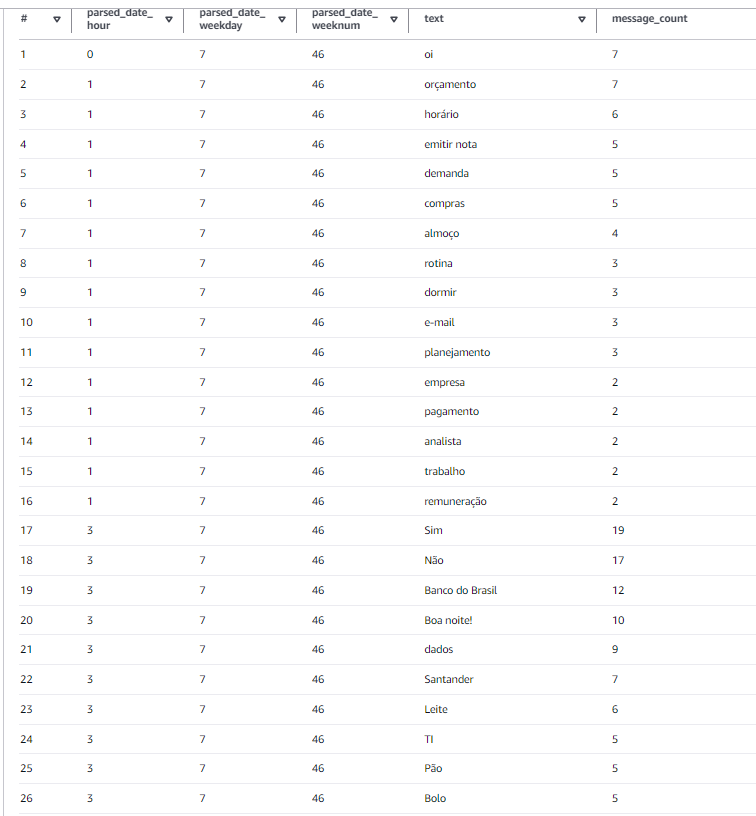

### 6.5 Há mensagens de bots?

```sql
SELECT
    user_is_bot,
    COUNT(*) AS message_count
FROM
    "telegram"
GROUP BY
    user_is_bot
ORDER BY
    message_count DESC;
```

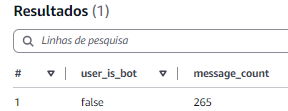

### 6.6 Há um horário que tende a ter mais mensagens?

```sql
SELECT
    hour(CAST(from_unixtime(date) AS timestamp)) AS hour_interval,
    COUNT(*) AS message_count
FROM
    "telegram"
GROUP BY
    hour(CAST(from_unixtime(date) AS timestamp))
ORDER BY
    message_count DESC
LIMIT 5;
```

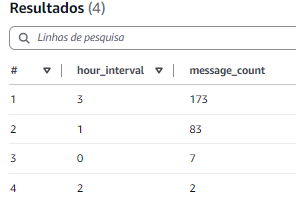

# 7. Análises

 A análise visa extrair insights sobre o comportamento dos usuários, como padrões de atividade, principais tópicos de conversa e características das mensagens. As informações obtidas podem ser úteis para entender a dinâmica do grupo e otimizar estratégias de comunicação.

* O número médio de mensagens enviadas nos dois dias é de 132,5.
* O número de mensagens enviadas no dia 17/11/2024 (195) foi significativamente maior do que no dia 16/11/2024 (70).
* Isso pode indicar um evento ou discussão específica que ocorreu no dia 17/11/2024, aumentando o volume de mensagens.


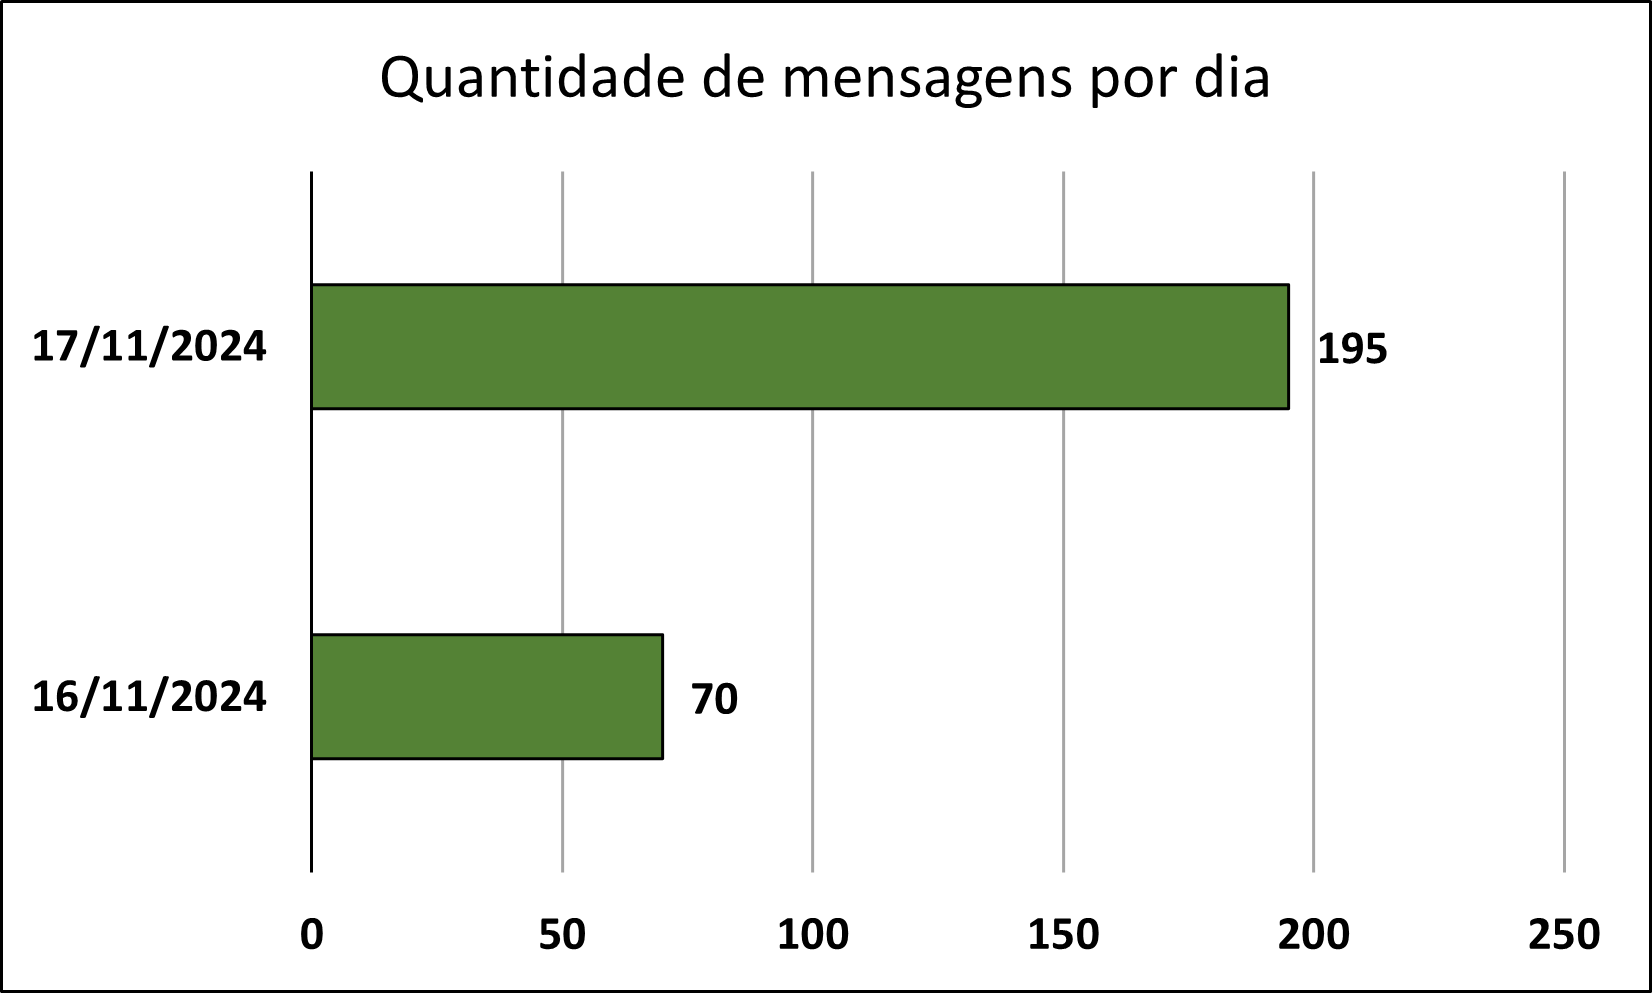



* O comprimento médio das mensagens varia de 1 a 94 caracteres.
* Paola enviou a mensagem mais curta (1 caractere) e Fonza enviou a mensagem mais longa (94 caracteres).
* O comprimento médio das mensagens de Fonza é maior do que o de Paola.
Isso pode indicar diferentes estilos de comunicação ou propósitos de mensagens entre os usuários.


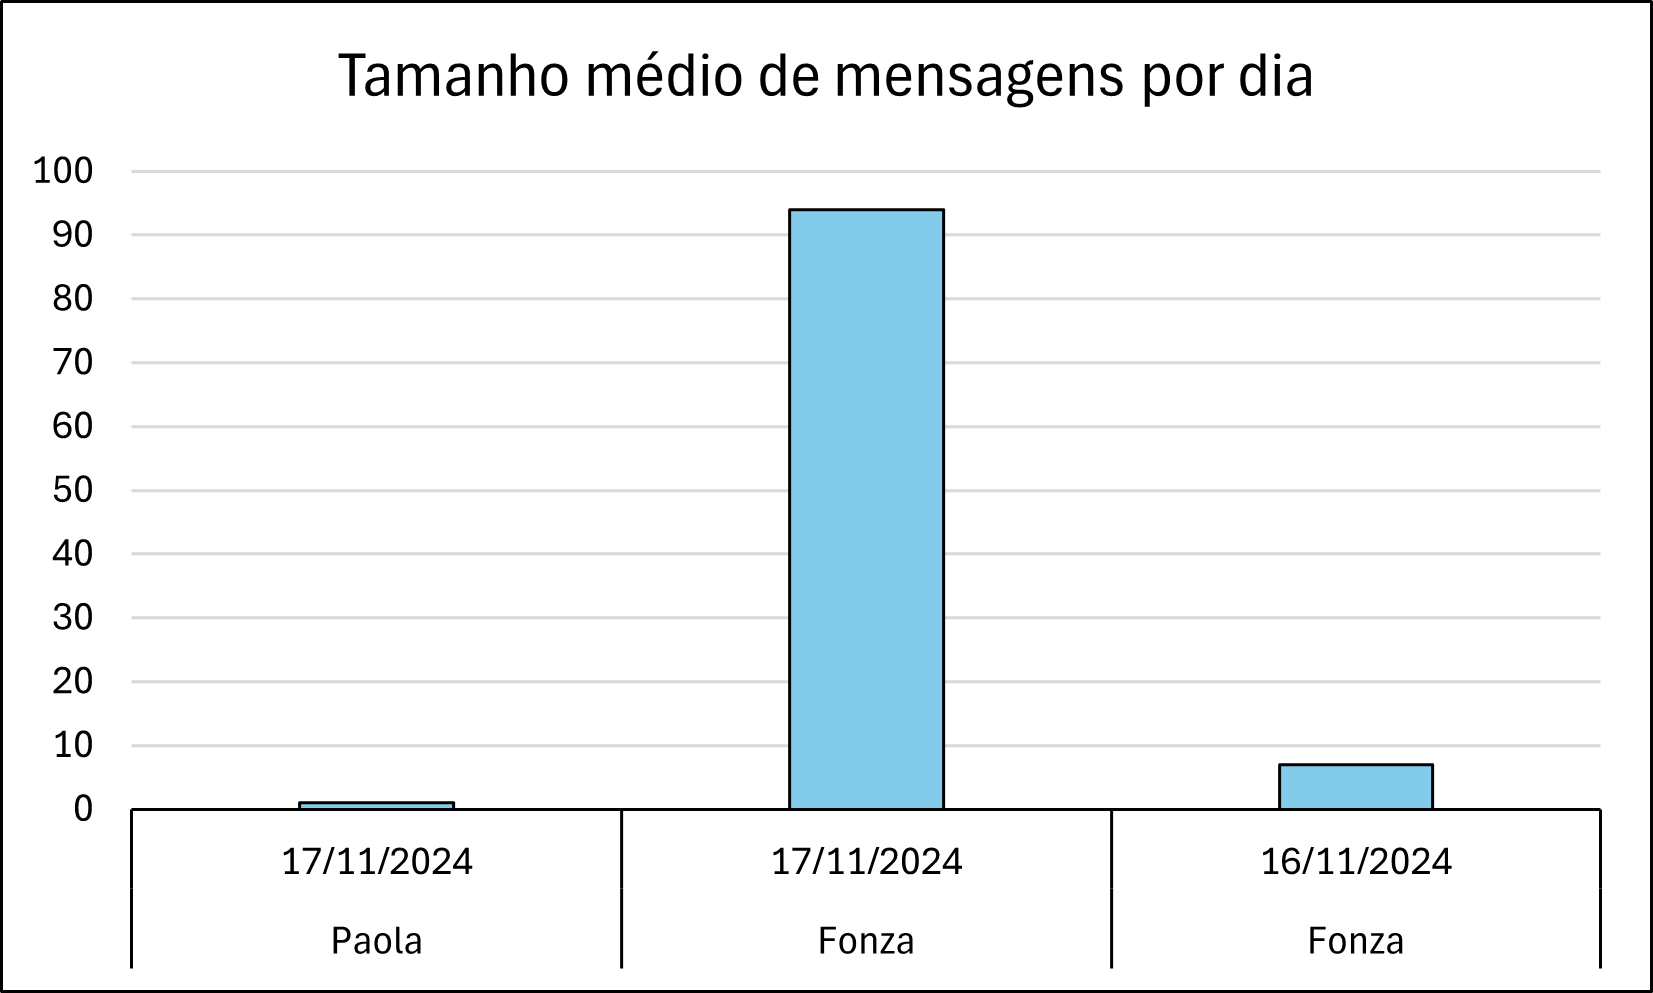

* A maioria das mensagens foi enviada no domingo, seguida pela segunda-feira.
* O pico de mensagens ocorreu às 3 da manhã, com 173 mensagens.
* Esses padrões refletem os hábitos de sono tardio, dada a preferência de comunicação dos usuários à noite, bem como a prevalência de mensagens no final de semana.

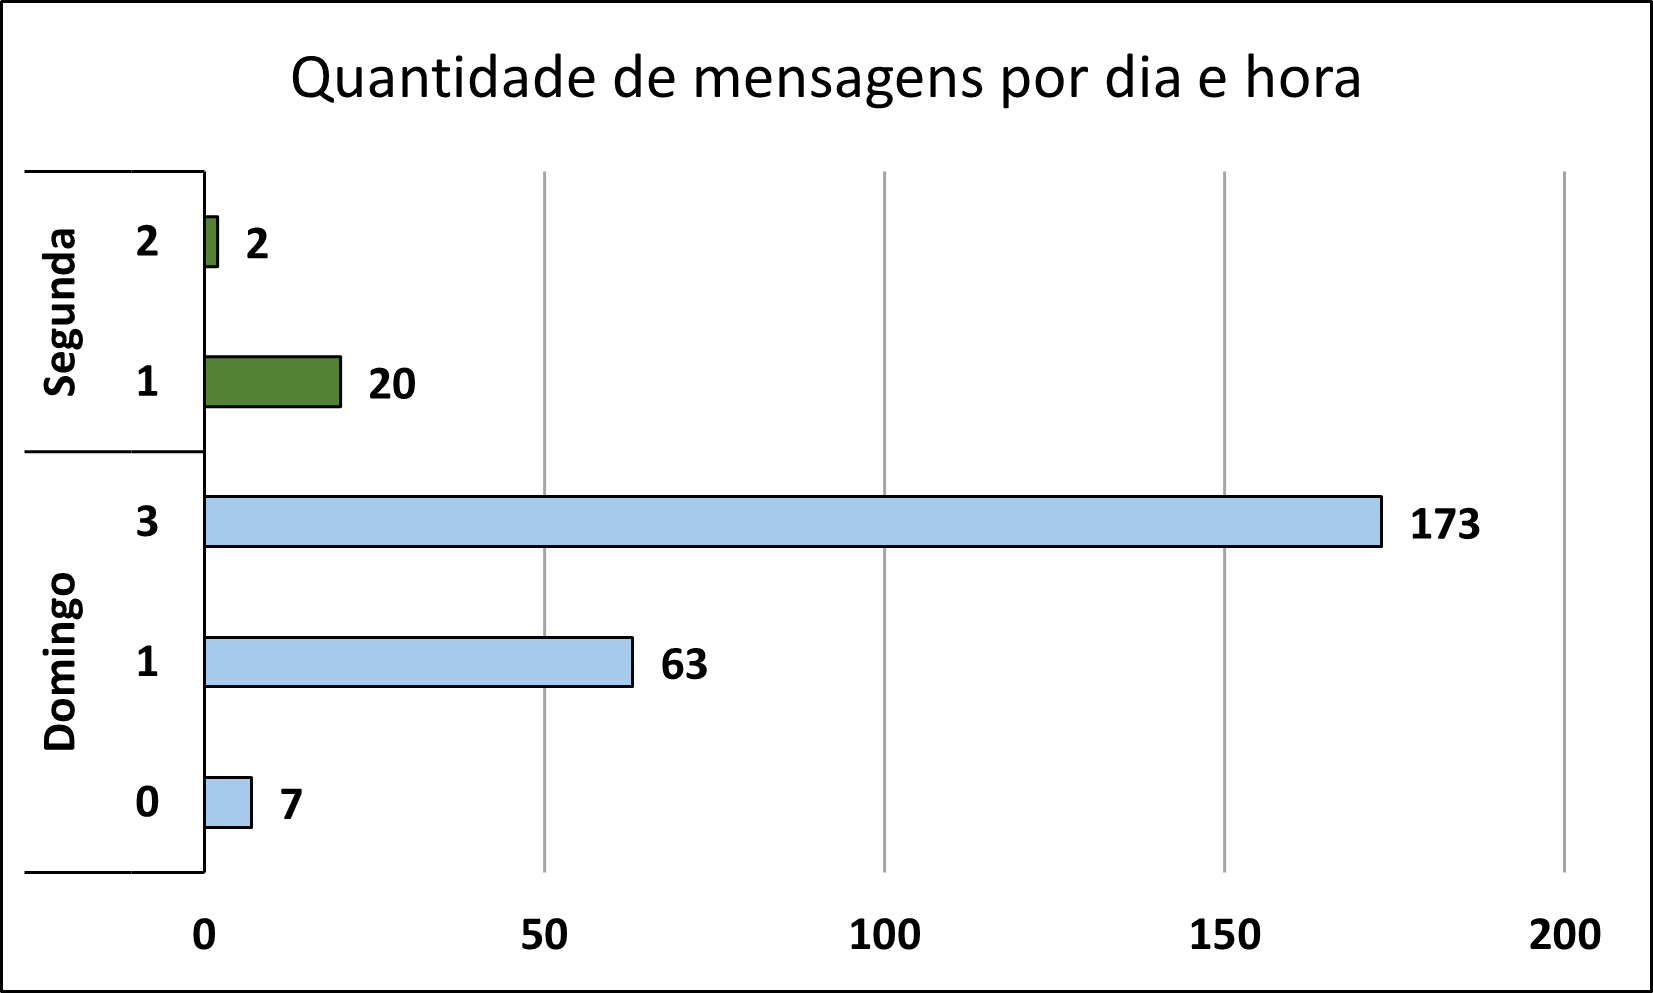

* As palavras mais recorrentes nas mensagens incluem "Sim", "Não", nomes de bancos como Santander, Nubank, Banco do Brasil, entre outros, além de termos relacionados ao mercado de trabalho, como "orçamento", "demanda", "e-mail", entre outros.
* Isso pode indicar que o grupo de Telegram é usado principalmente para fins profissionais ou relacionados a negócios.



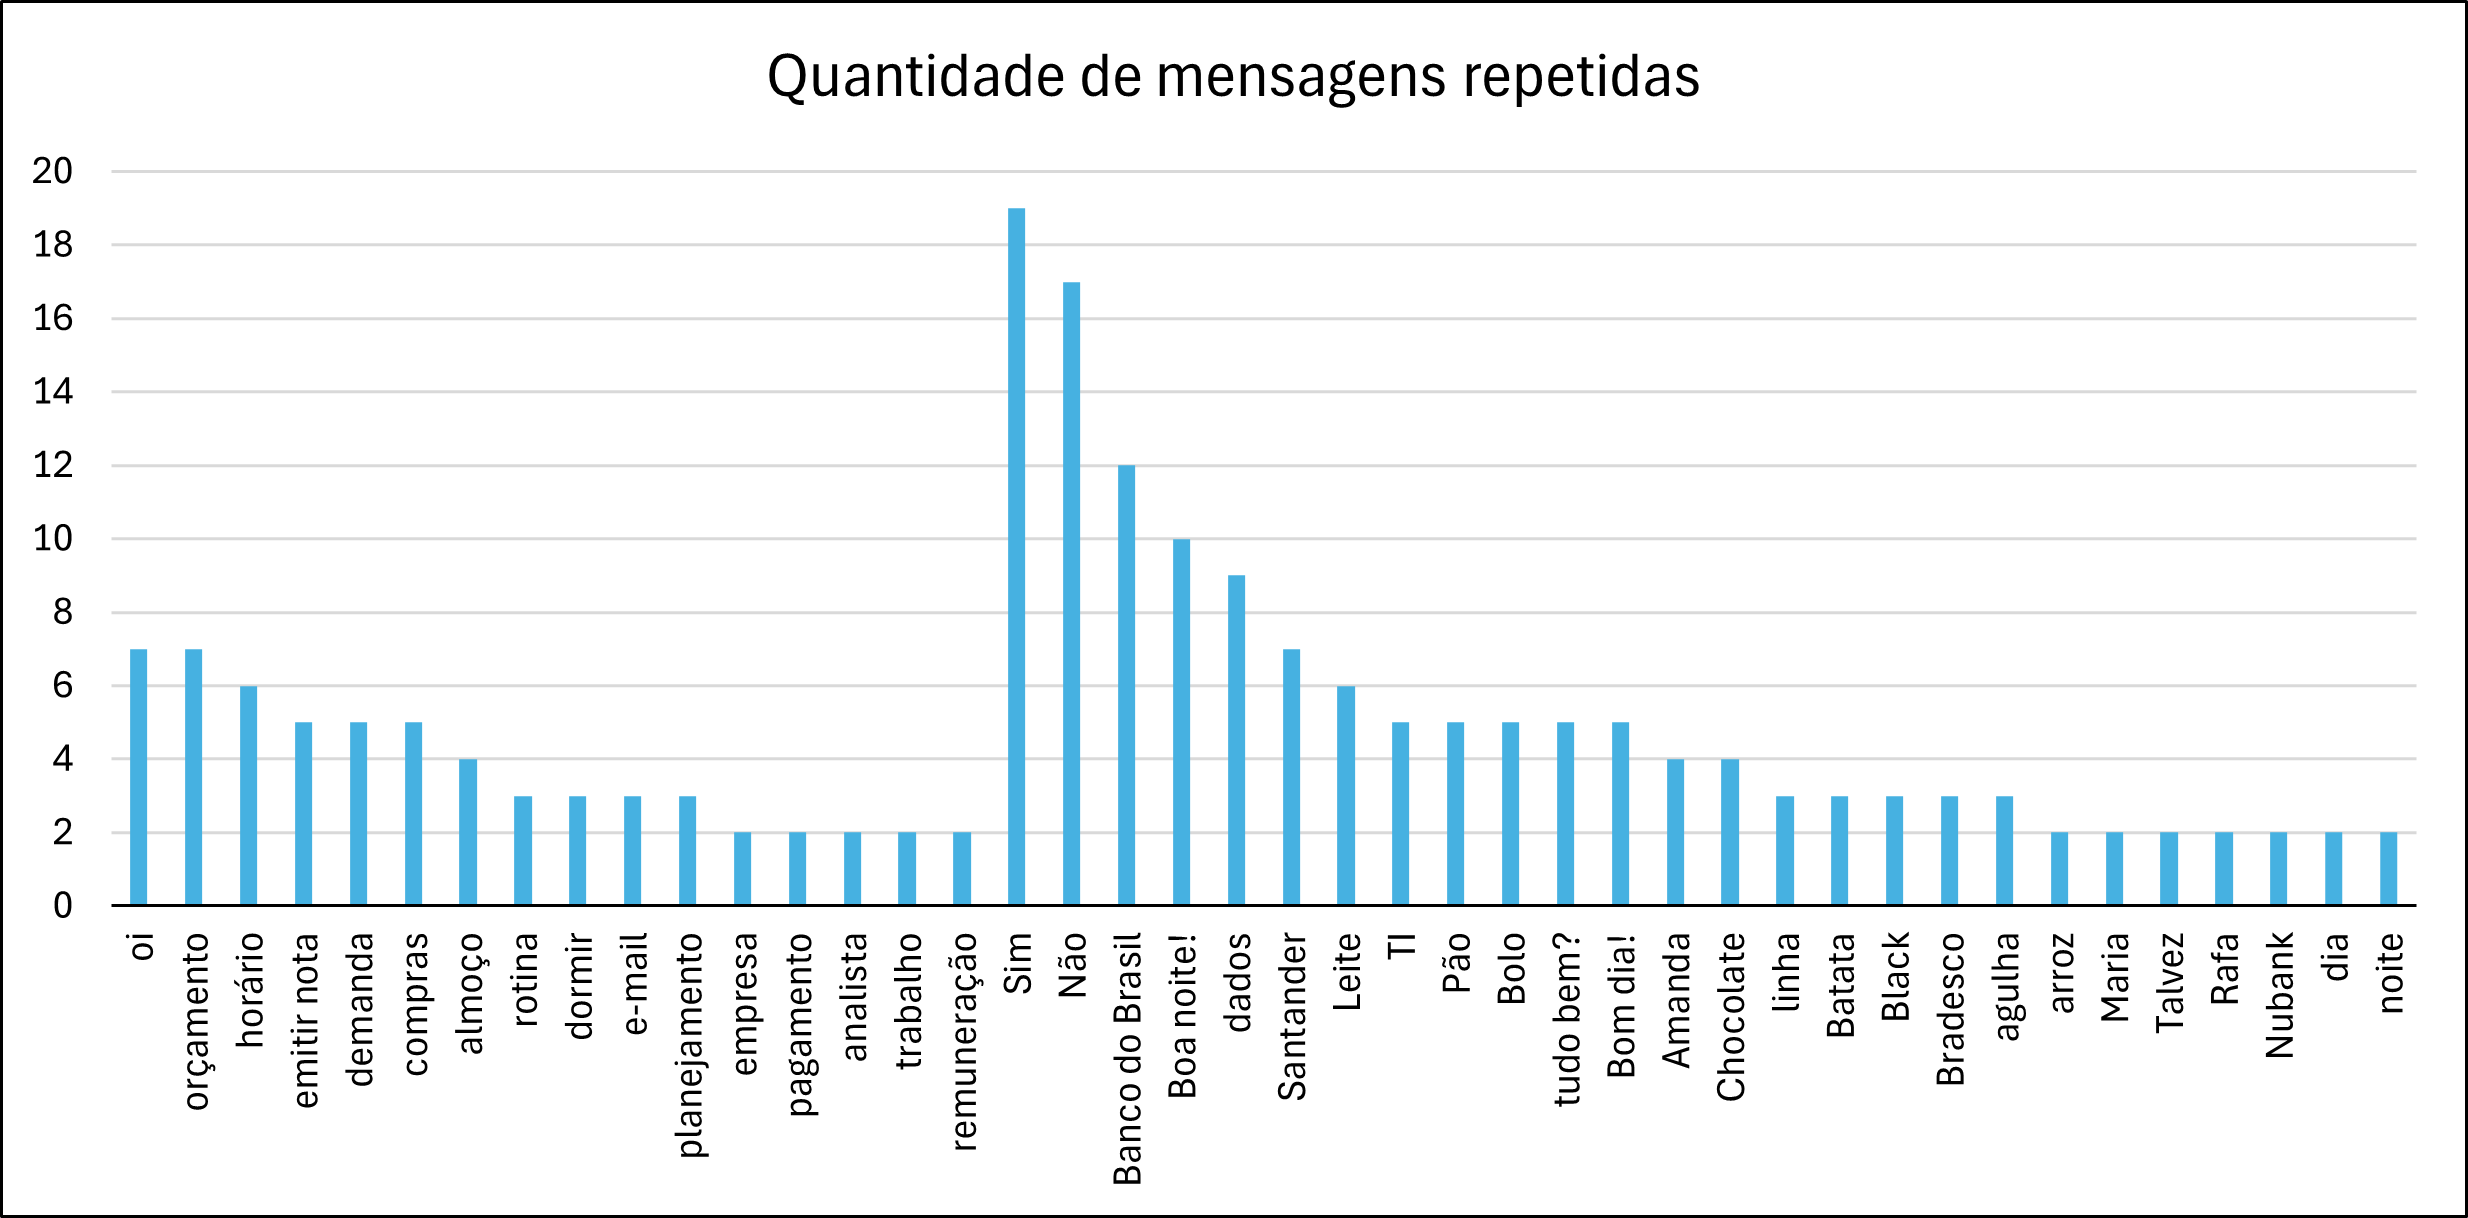


* A maioria das mensagens (265) foi enviada por usuários que não são bots.
* Isso pode indicar que o grupo de Telegram é usado principalmente para comunicação humana e não para interações automatizadas.

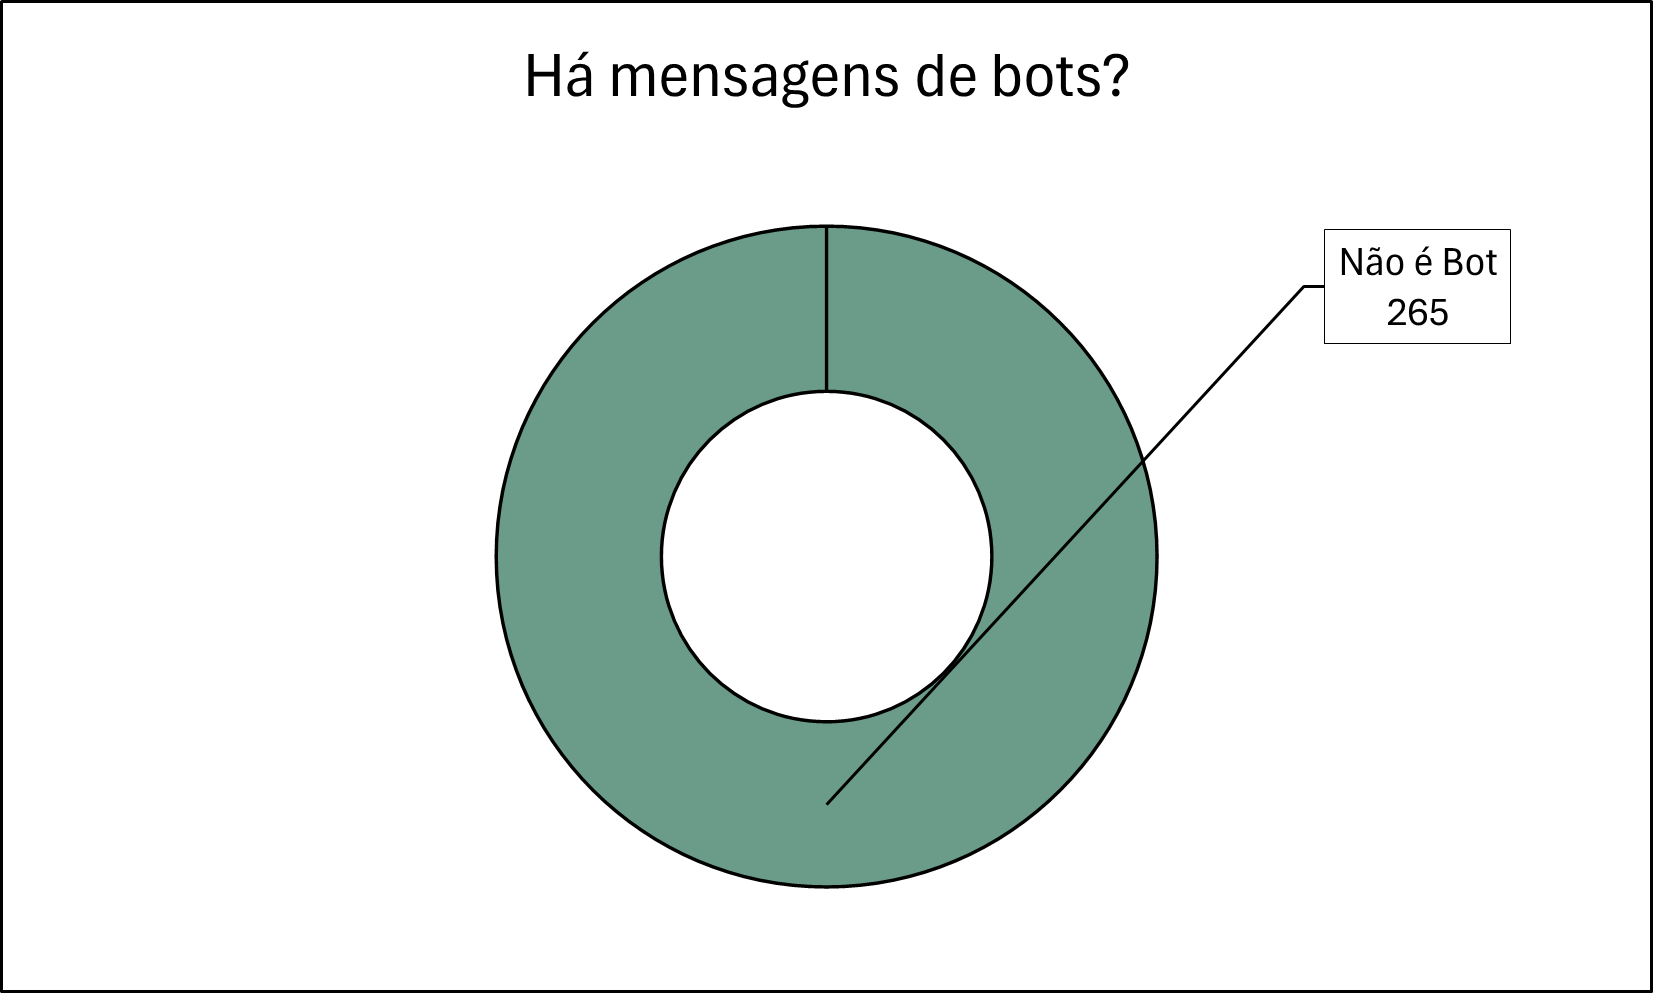

* O número de mensagens varia muito entre os intervalos de hora.
* O pico de mensagens ocorreu entre 3h e 4h, com 173 mensagens.
* O número de mensagens é significativamente menor entre 2h e 3h.
Isso pode indicar um evento ou discussão específica que ocorreu entre 3h e 4h, aumentando o volume de mensagens.

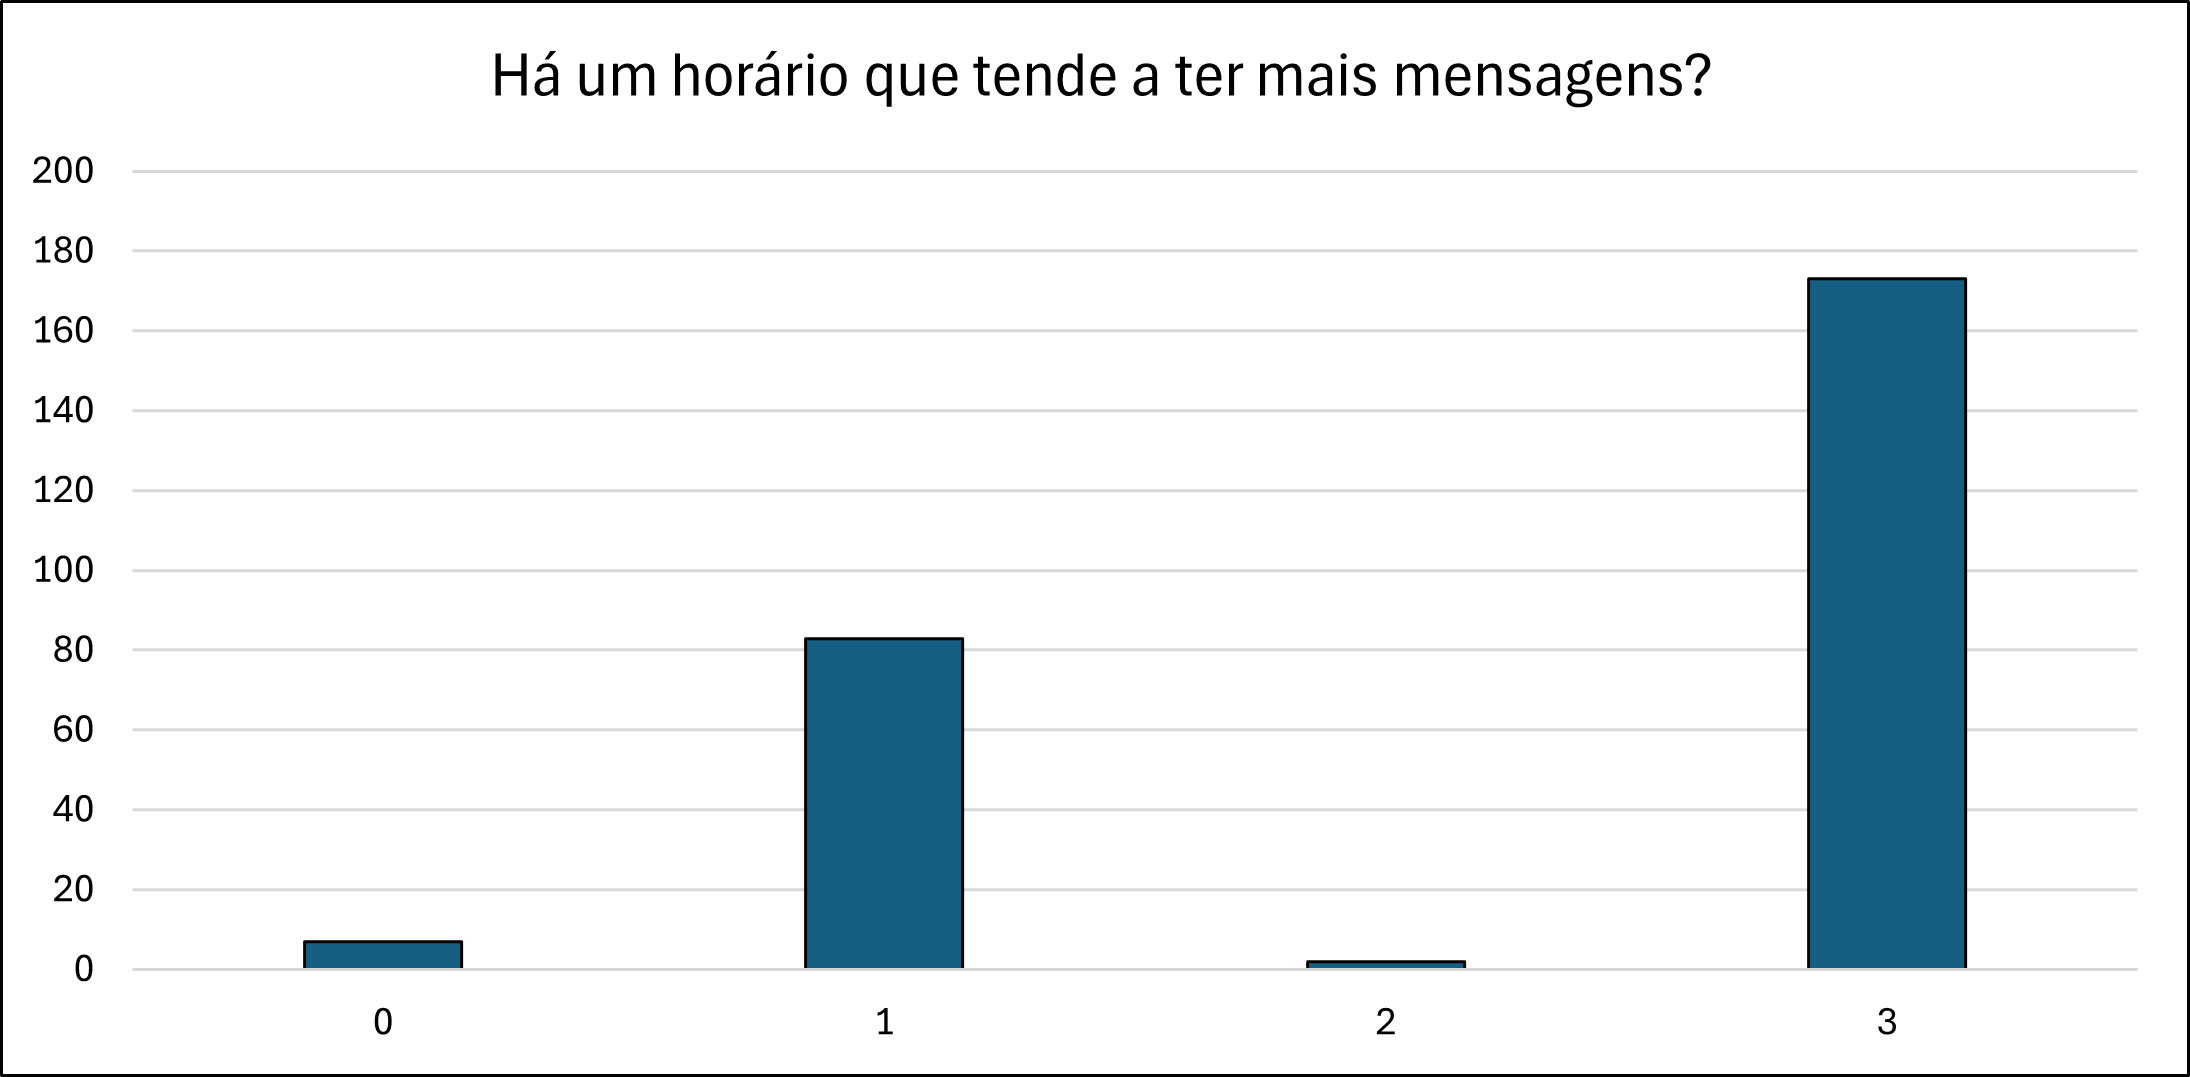

# 7. Conclusões


* **Pico de atividade às 3 da manhã:** Sugere evento específico ou hábitos noturnos dos usuários.
* **Mensagens frequentes que remetem ao ambiente de trabalho:** Indicam foco profissional ou comercial do grupo.
* **Variação no comprimento das mensagens:** Reflete diferentes estilos de comunicação entre os usuários (ex: Paola com mensagens curtas vs. Fonza com mensagens longas).
* **Predomínio de mensagens enviadas por pessoas:** Baixa participação de bots.
Concentração da atividade no domingo e na segunda-feira: Poucas mensagens nos demais dias da semana.